In [14]:
import torch
import torch.nn as nn
import torch.distributions as dist
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


In [ ]:

class GaussianMixture(nn.Module):
    def __init__(self, n_components, n_features):
        super(GaussianMixture, self).__init__()
        
        # Initialize mixture weights
        self.logit_pi = nn.Parameter(torch.zeros(n_components))
        
        # Initialize means randomly
        self.mu = nn.Parameter(torch.randn(n_components, n_features))
        
        # Initialize log variance
        self.log_var = nn.Parameter(torch.zeros(n_components, n_features))
    
    @property
    def pi(self):
        """Convert pi_logits to mixture probabilities using softmax"""
        return torch.softmax(self.pi_logits, dim=0)


    def forward(self, x):
        # Calculate log probabilities for each component
        log_probs = []
        log_prob_pi = F.log_softmax(self.logit_pi)
        for i in range(len(self.logit_pi)):
            distrib = dist.MultivariateNormal(self.mu[i], torch.diag(self.log_var[i].exp()))
            log_probs.append(distrib.log_prob(x) + log_prob_pi[i])

        log_probs = torch.stack(log_probs, dim=-1)

        # Calculate log likelihood
        log_likelihood = torch.logsumexp(log_probs, dim=-1)

        return -log_likelihood
    
    # def forward(self, x):
    #     # Compute Gaussian probability for each component
    #     log_likelihoods = torch.zeros(len(x), len(self.logit_pi))
        
    #     for k in range(len(self.logit_pi)):
    #         # Calculate Gaussian probability
    #         diff = x - self.mu[k]
    #         var = torch.exp(self.log_var[k])
    #         log_prob = -0.5 * (torch.log(2 * torch.tensor(np.pi)) + 
    #                           self.log_var[k] + 
    #                           (diff ** 2 / var))
    #         log_likelihoods[:, k] = log_prob.sum(dim=1)
        
    #     # Add log mixture weights
    #     log_likelihoods += self.logit_pi
        
    #     # Log sum exp trick for numerical stability
    #     max_log_likelihood = torch.max(log_likelihoods, dim=1, keepdim=True)[0]
    #     log_likelihoods -= max_log_likelihood
    #     log_likelihoods = torch.exp(log_likelihoods)
    #     total = torch.sum(log_likelihoods, dim=1)
        
    #     return -torch.log(total) - max_log_likelihood.squeeze()

# Training function
def train_gmm(model, data, n_epochs=200):
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    losses = []
    
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        loss = model(data).mean()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if (epoch + 1) % 100 == 0:
            print(f'Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}')
    
    return losses

# Visualization function
def plot_results(data, model, losses):
    plt.figure(figsize=(15, 5))
    
    # Plot the data and learned distributions
    plt.subplot(121)
    plt.scatter(data[:, 0].numpy(), data[:, 1].numpy(), alpha=0.5)
    
    # Plot the learned Gaussians
    x = torch.linspace(-5, 5, 100)
    y = torch.linspace(-5, 5, 100)
    xx, yy = torch.meshgrid(x, y)
    grid = torch.stack([xx.flatten(), yy.flatten()], dim=1)
    
    with torch.no_grad():
        z = -model(grid).reshape(100, 100)
    
    plt.contour(xx.numpy(), yy.numpy(), z.numpy())
    plt.title('Data and Learned Distributions')
    
    # Plot the loss curve
    plt.subplot(122)
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.tight_layout()
    plt.show()


In [15]:
def generate_mixture_data(n_samples=1000):
    """
    Generate samples from a mixture of 2 Gaussians using simple loops.
    Each sample is generated one by one.
    """
    # Define parameters
    weights = torch.tensor([0.4, 0.6])  # mixture weights
    means = torch.tensor([
        [-2.0, -2.0],  # mean of first Gaussian
        [2.0, 2.0]     # mean of second Gaussian
    ])
    stds = torch.tensor([
        [1.0, 1.0],    # std of first Gaussian
        [0.5, 0.5]     # std of second Gaussian
    ])
    
    # Initialize array to store samples
    samples = torch.zeros(n_samples, 2)
    
    # Generate one sample at a time
    for i in range(n_samples):
        # First, choose which Gaussian to sample from
        component = torch.multinomial(weights, 1).item()
        
        # Then generate a sample from that Gaussian
        for j in range(2):  # for each dimension
            # Generate random normal sample
            samples[i, j] = torch.normal(
                mean=means[component, j],
                std=stds[component, j]
            )
    
    return samples


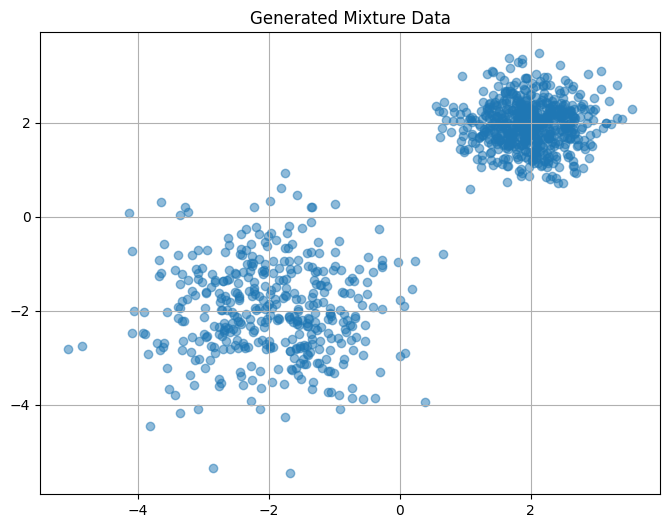

In [16]:

# Example usage
if __name__ == "__main__":
    torch.manual_seed(42)
    samples = generate_mixture_data(1000)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
    plt.title("Generated Mixture Data")
    plt.grid(True)
    plt.show()


/tmp/ipykernel_167872/3723319457.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_prob_pi = F.log_softmax(self.logit_pi)


Epoch 100/1600, Loss: 4.5822
Epoch 200/1600, Loss: 3.9705
Epoch 300/1600, Loss: 3.6173
Epoch 400/1600, Loss: 3.3824
Epoch 500/1600, Loss: 3.2511
Epoch 600/1600, Loss: 3.1394
Epoch 700/1600, Loss: 3.0246
Epoch 800/1600, Loss: 2.9164
Epoch 900/1600, Loss: 2.8266
Epoch 1000/1600, Loss: 2.7578
Epoch 1100/1600, Loss: 2.7107
Epoch 1200/1600, Loss: 2.6842
Epoch 1300/1600, Loss: 2.6724
Epoch 1400/1600, Loss: 2.6683
Epoch 1500/1600, Loss: 2.6672
Epoch 1600/1600, Loss: 2.6670


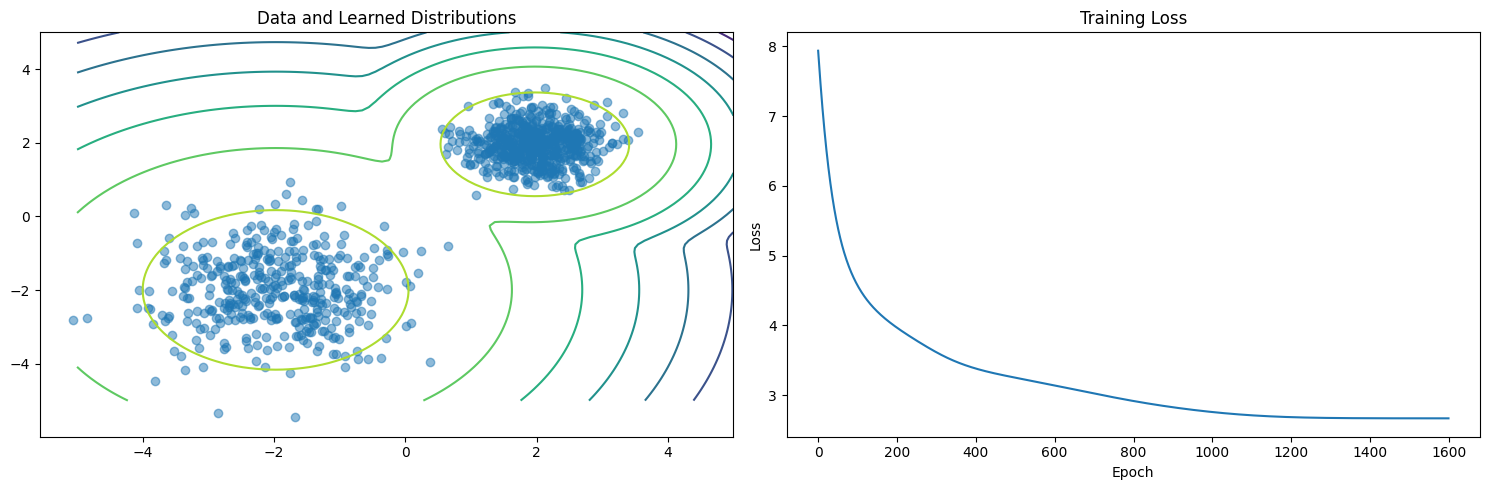


Learned Parameters:
Mixture weights (pi): tensor([0.5940, 0.4060])
Means (mu):
tensor([[ 1.9742,  1.9598],
        [-1.9753, -1.9939]])
Variances:
tensor([[0.2572, 0.2468],
        [0.8863, 1.0143]])


In [18]:

# Main execution
def main():
    # Set random seed for reproducibility
    torch.manual_seed(42)
    
    # Generate synthetic data
    data = generate_mixture_data()
    
    # Create and train model
    model = GaussianMixture(n_components=2, n_features=2)
    losses = train_gmm(model, data, n_epochs=1600)
    
    # Plot results
    plot_results(data, model, losses)
    
    # Print learned parameters
    print("\nLearned Parameters:")
    print(f"Mixture weights (pi): {torch.softmax(model.logit_pi.data, dim=0)}")
    print(f"Means (mu):\n{model.mu.data}")
    print(f"Variances:\n{torch.exp(model.log_var.data)}")

if __name__ == "__main__":
    main()